# Project 1: Ising Model

In [1]:
%matplotlib notebook   

import matplotlib    # Library used for plotting
import numpy as np   # Numerical library
import matplotlib.pyplot as plt # Plot commands
import functools # what the f*** does this module do?

#from matplotlib import rc
#rc('text', usetex = True)
#rc('font', size = 12, family = 'Times New Roman')

# Define some colors using the RGB format
my_lilac = (169/255,89/255,201/255);
my_blue = (50/255,120/255,218/255);
my_green = (106/255,178/255,71/255);
my_orange = (209/255,135/255,46/255);
my_red = (215/255,67/255,84/255);

## 1D Ising

A 1D Ising model is composed of a chain of interacting spins. In its simplest version, the interaction is limited to the nearest neighbors so that the energy is given by

$$
E = -J\sum_i s_i s_{i + 1}\,,
$$

where $s_i = \pm 1$ is the spin on the $i$th site and $J > 0$. One can see that the energy is minimized if all the spins point in the same direction.

As you will learn later in more detail in your courses, spins also interact with the magnetic field $\mathbf{B}$. Aligning spins with the magnetic field lowers their energy. Therefore, we can extend our energy expression as

$$
E = -J\sum_i s_i s_{i + 1} - B \sum_i s_i\,.
$$

This means that if $B>0$, up-spins will be favored energetically; if $B<0$, down-spins will be preferred.

In this problem, we will encounter three energy parameters: $J$, $B$ and $k_B T$. As a matter of convenience, we can express all the energies in the system in terms of the spin-spin interaction $J$. This amounts to setting $J = 1$ so that

$$
E = -\sum_i s_i s_{i + 1} - B \sum_i s_i\,.
$$

This way, we don't have to worry about the actual magnitudes of $B$ and $k_B T$. Instead, we care about how they compare to $J$.

#### IMPORTANT:

In each of the following questions use the results of the earlier questions, when applicable! Don't reinvent the wheel!

#### Question 1

Before we start playing with the spin system, we need to create it. Write a function that takes the number of spins in the chain $N$ and returns a random configuration of spins. It is most convenient to represent the spin configuration as a list of $\pm 1$'s.

In [255]:
# # Function for a random chain generation
# def spin_system(n):
#     our_system = np.random.random(n)
#     for ii in range(n):
#         if our_system[ii] < 0.5:
#             our_system[ii] = -1
#         else:
#             our_system[ii] = 1
#     return our_system

# a = spin_system(100)
# b = spin_system(5)
# print(a)

def spin_system(n):
    return np.sign(2 * np.random.random(n) - 1)

spin_system(10)

array([-1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.])

Each spin, except the two at the ends, has two neighbors (one on the left and one on the right). To avoid edge effects, we will turn the atomic chain into a circle so that the first and the last spins become adjacent. This way, *every* spin has two neighbors.

#### Question 2
Write a function that takes three parameters -- a list of spins, the magnetic field $B$, and a spin index -- and returns the energy cost of flipping the spin (this energy can be positive or negative). Remember that we set $J = 1$ in the expression for the energy above.

Don't forget about the ring structure of the chain! (Modulo is your friend)

In [256]:
# # Function to compute neighbours in a ring 
# def give_neighbours(our_list, i):
#     n = len(our_list) # Number of elements in our list
#     next_neighbour = (i+1)%n
#     previous_neighbour = (i-1+n)%n
#     return next_neighbour, previous_neighbour

# # Function to compute the energy cost of flipping a spin
# def energy_cost(our_list, B, i):
#     s = our_list
#     # Rearrange the equation to calculate the energy cost, ΔE = E(After flipping) - E(Before flipping)
#     cost = 2*s[i]*(s[give_neighbours(our_list, i)[0]] + s[give_neighbours(our_list, i)[1]]) + 2*B*s[i]
#     return cost 

def give_neighbours(our_list, i):
    n = len(our_list) # Number of elements in our list
    next_neighbour = (i+1)%n
    previous_neighbour = (i-1+n)%n
    return (next_neighbour, previous_neighbour)

def energy_cost(our_list, B, i):
    s = our_list
    # Rearrange the equation to calculate the energy cost, ΔE = E(After flipping) - E(Before flipping)
    a = give_neighbours(our_list, i)
    cost = 2*s[i]*(s[a[0]] + s[a[1]]) + 2*B*s[i]
    return cost 


# Sanity Check 1: 
b = spin_system(10)
print(b)
for x in range(10):
    y = energy_cost(b, 0, x)
    print(y)
    
# Sanity Check 2:
c = [-1 for i in range(10)]
c[5] = 1
print(c)
for x in range(10):
    y = energy_cost(c, 0, x)
    print(y)
    
# Sanity Check 3: if B!=0
d = [1 for i in range(10)]
d[5] = -1
print(d)
for x in range(10):
    y = energy_cost(d, 100, x)
    print(y)

[ 1. -1. -1.  1. -1.  1. -1. -1. -1. -1.]
-4.0
-0.0
-0.0
-4.0
-4.0
-4.0
-0.0
4.0
4.0
-0.0
[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1]
4
4
4
4
0
-4
0
4
4
4
[1, 1, 1, 1, 1, -1, 1, 1, 1, 1]
204
204
204
204
200
-204
200
204
204
204


As we discussed in class, spins can spontaneously flip due to the interaction with the environment.

#### Question 3

We are going to write a function that will try to flip a single spin in the chain. It will take three parameters: the chain array, $B$, and the temperature $k_B T$.

The flipping will be perfomed using a variation of the acceptance-rejection method. It goes as follows:
1. Randomly choose a spin that we will try to flip.
2. Get the flip cost $\Delta E$ using **Question 2**.
2. If $\Delta E < 0$, the flipped configuration is energetically preferred. Therefore, flip the spin.
3. Otherwise, draw a random number $p \in [0,1]$ and compare $e^{-\beta\Delta E}$ to it. If $e^{-\beta\Delta E} > p$, flip the spin.



In [254]:
# Function to flip a single spin
def single_flip(chain_array, B, kBT):
    # Randomly choose a spin that we will try to flip.
    i = np.random.choice(range(len(chain_array)))
    
    # Get the flip cost  Δ𝐸  using Question 2.
    E = energy_cost(chain_array, B, i)
        
    p = np.random.random()
    
    # If  Δ𝐸<0 , the flipped configuration is energetically preferred. Therefore, flip the spin.
    if E < 0:
        if chain_array[i] == 1:
            chain_array[i] = -1
        else:
            chain_array[i] = 1
    # Otherwise, draw a random number  𝑝∈[0,1]  and compare  𝑒−𝛽Δ𝐸  to it. If  𝑒−𝛽Δ𝐸>𝑝 , flip the spin.
    elif np.exp(-E/kBT) > p:
        if chain_array[i] == 1:
            chain_array[i] = -1
        else:
            chain_array[i] = 1
    
    return chain_array

temp = 0.00001
print(d)
e = single_flip(d, 0, temp)
print(e)
print(d)

[1, 1, 1, 1, 1, -1, 1, 1, 1, 1]
[1, 1, 1, 1, -1, -1, 1, 1, 1, 1]
[1, 1, 1, 1, -1, -1, 1, 1, 1, 1]


### Intermission

At this point, stand up, relax a bit. You are done with the "dumb" portion of this part of the project. Make sure you understand what the functions you have so far can do.

Next, we're going to make some science!

### Intermission Over

So far we know the following:
1. Spins prefer to align with their neighbors
2. Spins prefer to point in the direction of the magnetic field
3. Temperature messes up the order

We would like to quantify the order in our system. To this end, we define a quantity called *magnetization*, given by

$$
M = \frac{1}{N}\sum_i s_i\,,
$$

where $N$ is the total number of spins in the system.

If $M = \pm 1$, all spins are aligned and point either up ($M = 1$) or down ($M = -1$). Other values of $M$ mean that the spins are not completely aligned. We want to know how magnetized a system becomes for different values of $k_B T$ and $B$. To answer this question, we will proceed as follows:

1. First, we will generate a random chain of some length
2. We will then apply the function you wrote in **Question 3** repeatedly to this chain. Each application corresponds to a time step.
3. After a sufficiently long time, we assume that the magnetization will settle on some number and won't change (aside from some small fluctuations due to the temperature).
4. At this point, we can compute the magnetization of the system.
5. We can perform this at different $k_B T$ and $B$ to see the role that the temperature and the magnetic field have on magnetization.
6. Finally, we can repeat this process several times to make sure we get consistent results.

Your goal here is to obtain plots of $M$ *vs.* $B$ for several representative values of $k_B T$. What do you see? Can you get your system to have a finite $M$ at any $T$ for $B = 0$? Describe your results.

*Suggestion: Once you know that you are running your simulations for enough time steps, play with $k_B T$ and $B$. Explore. Make the temperature really small and really large. What changes? This is your virtual lab, mess with the system!*

It turns out that we know the analytical result for the magnetization in 1D:

$$
M = \frac{\sinh\left(\frac{B}{k_B T}\right)}{\sqrt{e^{-\frac{4 J}{k_BT}} + \sinh^2\left(\frac{B}{k_B T}\right)}}\,.
$$

Show that your results agree with the formula.

In [47]:
# Function to calculate magnetization, M
def magnetization(chain_array):
    N = len(chain_array)
    #print(N)
    M = 0
    for ii in range(N):
        M += chain_array[ii]
        #print(M)
    M = M / N
    #print(M)
    return M

print(magnetization(d))

0.8


In [48]:
# Step 1: First, we will generate a random chain of some length
length = 100
our_chain = spin_system(length)
print(our_chain)

[ 1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.
 -1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1.
  1.  1.  1.  1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1.  1.
  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1.
 -1.  1. -1. -1.  1. -1.  1. -1.  1.  1.]


In [49]:
# Step 2: We will then apply the function you wrote in Question 3 repeatedly to this chain. 
# Each application corresponds to a time step.

time_steps = 100 # Lets do 100 time steps
B = 0 # Lets initially set the magnetic field to 0
kBT = 1

for ii in range(time_steps):
    single_flip(our_chain, B, kBT)
    #print(magnetization(our_chain))

<IPython.core.display.Javascript object>


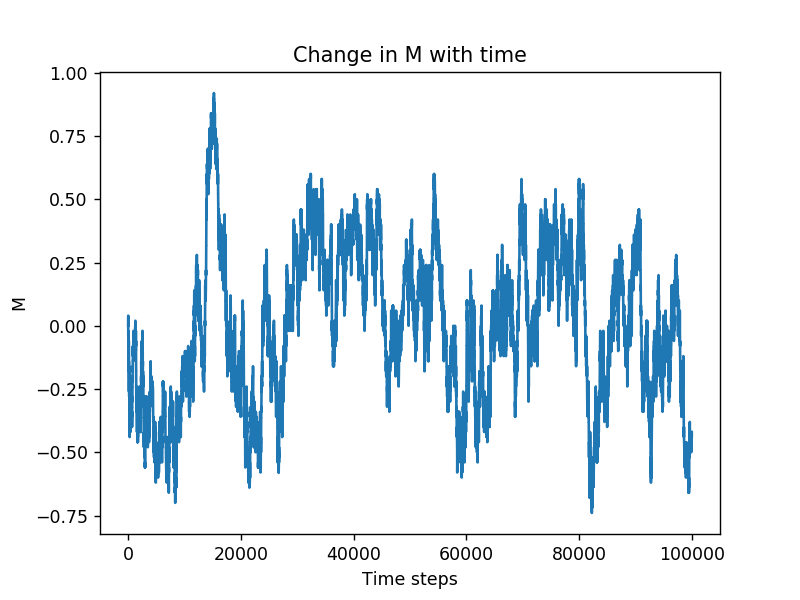

In [50]:
# Step 3: After a sufficiently long time, we assume that the magnetization will settle on some number and won't change 
# Aside from some small fluctuations due to the temperature.
# When B = 0

our_chain = spin_system(length)

time_steps = 100000 # Lets do 100000 time steps which is a very large number
B = 0 # Lets initially set the magnetic field to 0
kBT = 1

M_scores = [] # Create an empty list to store the magnetization scores after each timestep

for ii in range(time_steps):
    single_flip(our_chain, B, kBT)
    M_value = magnetization(our_chain)
    M_scores.append(M_value)
    #print(M_value)
    
#print(M_scores[time_steps - 1])
    
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the magnetization scores vs. timesteps
ax.plot(M_scores)
ax.set(xlabel = "Time steps"
      , ylabel = "M"
      , title = "Change in M with time") 
#ax.set_aspect(aspect = "equal")
plt.show()

<IPython.core.display.Javascript object>


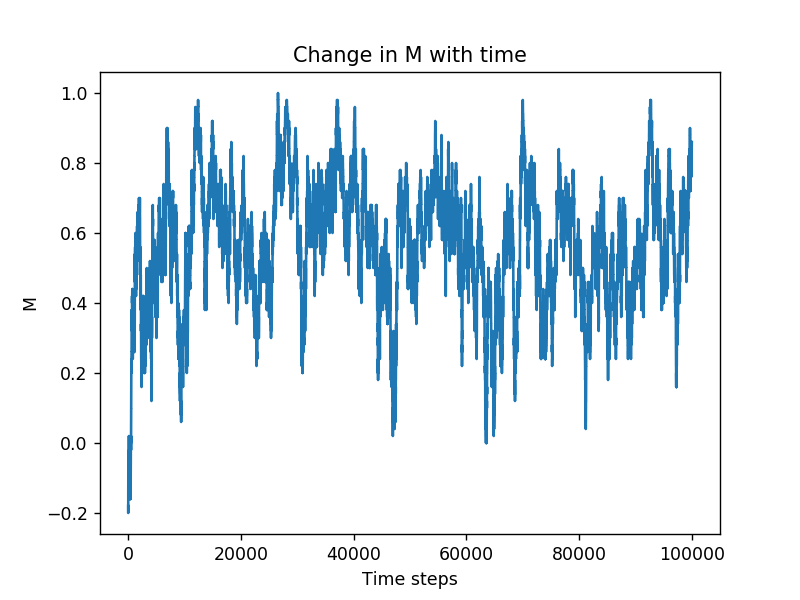

In [56]:
# Step 3: (Continued) When B > 0
B = 0.1 # B > 0, up-spins will be preferred

our_chain = spin_system(length)

time_steps = 100000 # Lets do 100000 time steps which is a very large number
kBT = 1

M_scores = [] # Create an empty list to store the magnetization scores after each timestep

for ii in range(time_steps):
    single_flip(our_chain, B, kBT)
    M_value = magnetization(our_chain)
    M_scores.append(M_value)
    #print(M_value)
    
#print(M_scores[time_steps - 1])
    
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the magnetization scores vs. timesteps
ax.plot(M_scores)
ax.set(xlabel = "Time steps"
      , ylabel = "M"
      , title = "Change in M with time") 
#ax.set_aspect(aspect = "equal")
plt.show()

<IPython.core.display.Javascript object>


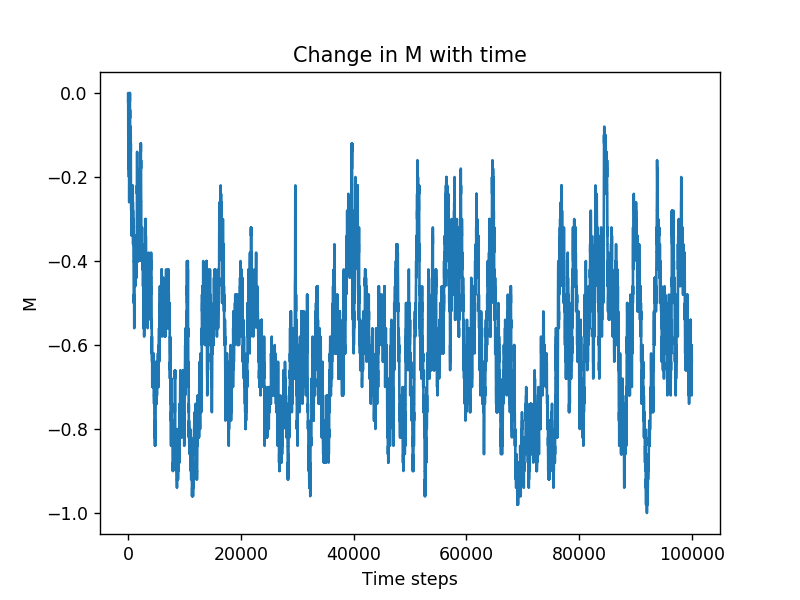

In [57]:
# Step 3: (Continued) When B < 0
B = -0.1 # B < 0, down-spins will be preferred

our_chain = spin_system(length)

time_steps = 100000 # Lets do 100000 time steps which is a very large number
kBT = 1

M_scores = [] # Create an empty list to store the magnetization scores after each timestep

for ii in range(time_steps):
    single_flip(our_chain, B, kBT)
    M_value = magnetization(our_chain)
    M_scores.append(M_value)
    #print(M_value)
    
#print(M_scores[time_steps - 1])
    
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the magnetization scores vs. timesteps
ax.plot(M_scores)
ax.set(xlabel = "Time steps"
      , ylabel = "M"
      , title = "Change in M with time") 
#ax.set_aspect(aspect = "equal")
plt.show()

In [58]:
# Step 4: At this point, we can compute the magnetization of the system.
print(M_scores[time_steps - 1])

-0.64


In [59]:
# Step 4: (Continued)
# Function to compute magnetization of a random system, given the (1) kBT, (2) B, (3) number of time steps and (4) length of chain
def system_magnetization(kBT, B, time_steps, length):
    our_chain = spin_system(length)
    
    M_scores = [] # Create an empty list to store the magnetization scores after each timestep
    
    for ii in range(time_steps):
        single_flip(our_chain, B, kBT)
        M_value = magnetization(our_chain)
        M_scores.append(M_value)
        #print(M_value)
    
    #print(M_scores[time_steps - 1])
    
    return M_scores[time_steps - 1]

<IPython.core.display.Javascript object>


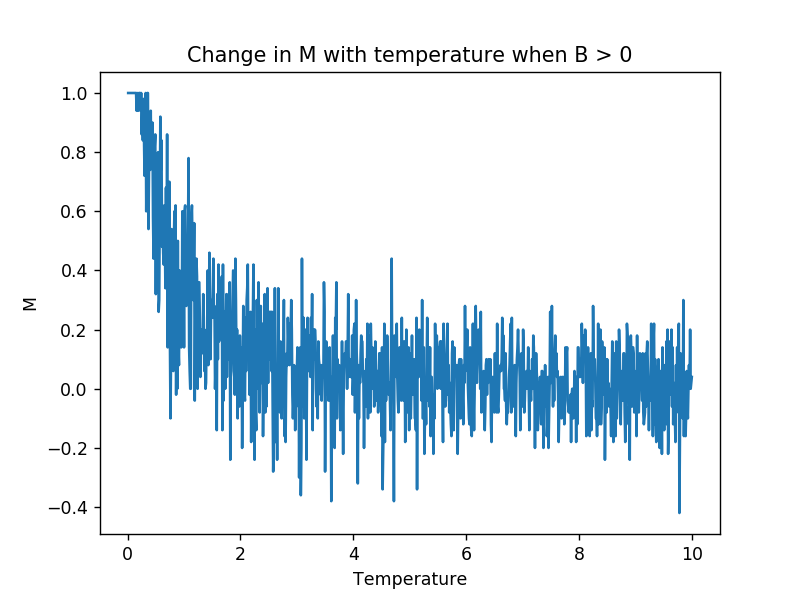

In [65]:
# Step 5: We can perform this at different  𝑘𝐵𝑇  and  𝐵  to see the role that the temperature and the magnetic field have on magnetization.
# Investigate the role of temperature on magnetization. (When B > 0)

B = 0.1 # effect of magnetic field. Lets set it to 0.1. It is greater than 0, so up-spins will be preferred
length = 100 # 100 seems like a reasonably sized chain
time_steps = 100*10 # 1000 time steps for a chain of length of 100 means that on average there will be 10 attempts per chain element. We hope this is a reasonable estimate of the number of time steps needed for the M to reach a constant value.

temp_range = range(1, 1001, 1)
kBT = [ii*(0.01) for ii in temp_range] 

M_list = []

for ii in kBT:
    m = system_magnetization(ii, B, time_steps, length)
    M_list.append(m)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(kBT, M_list)

ax.set(xlabel = "Temperature"
      , ylabel = "M"
      , title = "Change in M with temperature when B > 0") 
#ax.set_aspect(aspect = "equal")
plt.show()

# Interpretation: 
# At very low temperatures, the magnetization is stuck with a particular combination. In our case, since B > 0, the combinations with up-spins are preferred.
# As we increase temperature, spins can spontaneously flip with higher probability. Refer back to the exponential term in our single_flip function.
# Thus at very high temperatures, the magnetization can wander around.

<IPython.core.display.Javascript object>


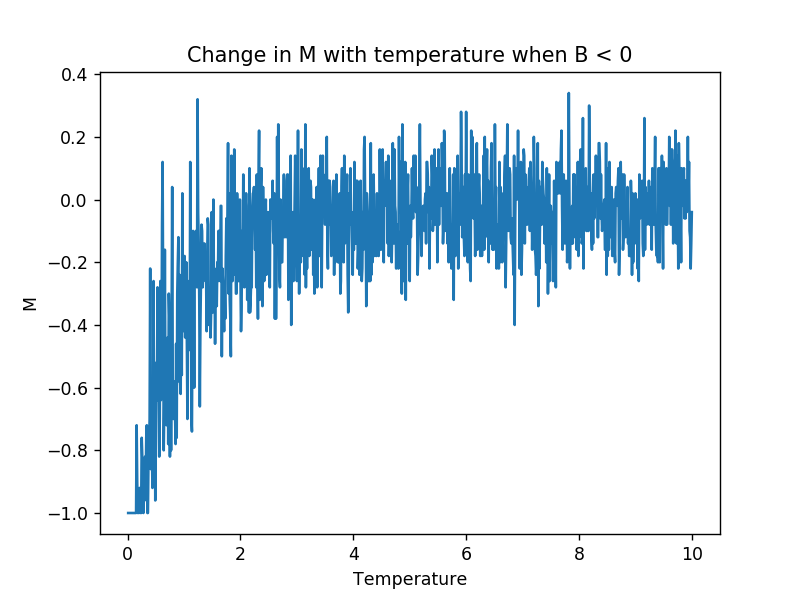

In [67]:
# Step 5: (Continued)
# Investigate the role of temperature on magnetization. (When B < 0)

B = -0.1 # effect of magnetic field. Lets set it to -0.1. It is lesser than 0, so down-spins will be preferred
length = 100 # 100 seems like a reasonably sized chain
time_steps = 100*10 # 1000 time steps for a chain of length of 100 means that on average there will be 10 attempts per chain element. We hope this is a reasonable estimate of the number of time steps needed for the M to reach a constant value.

temp_range = range(1, 1001, 1)
kBT = [ii*(0.01) for ii in temp_range] 

M_list = []

for ii in kBT:
    m = system_magnetization(ii, B, time_steps, length)
    M_list.append(m)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(kBT, M_list)

ax.set(xlabel = "Temperature"
      , ylabel = "M"
      , title = "Change in M with temperature when B < 0") 
#ax.set_aspect(aspect = "equal")
plt.show()

# Interpretation: 
# At very low temperatures, the magnetization is stuck with a particular combination. In our case, since B < 0, the combinations with down-spins are preferred.
# As we increase temperature, spins can spontaneously flip with higher probability. Refer back to the exponential term in our single_flip function.
# Thus at very high temperatures, the magnetization can wander around.

<IPython.core.display.Javascript object>


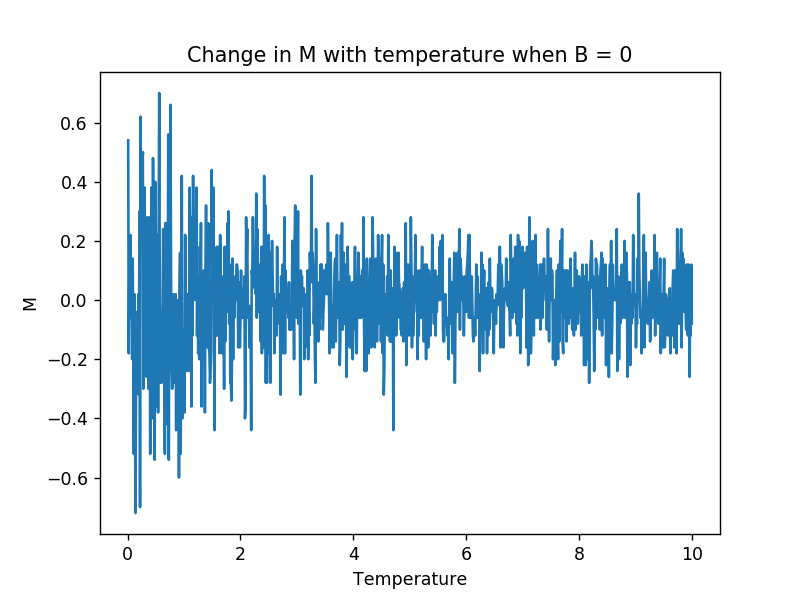

In [89]:
# Step 5: (Continued)
# Investigate the role of temperature on magnetization. (When B = 0)

B = 0 # effect of magnetic field. Lets set it to 0. Neither up-spins or down-spins are preferred.
length = 100 # 100 seems like a reasonably sized chain
time_steps = 100*10 # 1000 time steps for a chain of length of 100 means that on average there will be 10 attempts per chain element. We hope this is a reasonable estimate of the number of time steps needed for the M to reach a constant value.

temp_range = range(1, 1001, 1)
kBT = [ii*(0.01) for ii in temp_range] 

M_list = []

for ii in kBT:
    m = system_magnetization(ii, B, time_steps, length)
    M_list.append(m)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(kBT, M_list)

ax.set(xlabel = "Temperature"
      , ylabel = "M"
      , title = "Change in M with temperature when B = 0") 
#ax.set_aspect(aspect = "equal")
plt.show()

# Interpretation: 
# At very low temperatures, the magnetization is stuck with a particular combination. In our case, since B = 0, the combinations with either all down-spins or up-spins are preferred.
# As we increase temperature, spins can spontaneously flip with higher probability. Refer back to the exponential term in our single_flip function.
# Thus at very high temperatures, the magnetization can wander around.

<IPython.core.display.Javascript object>


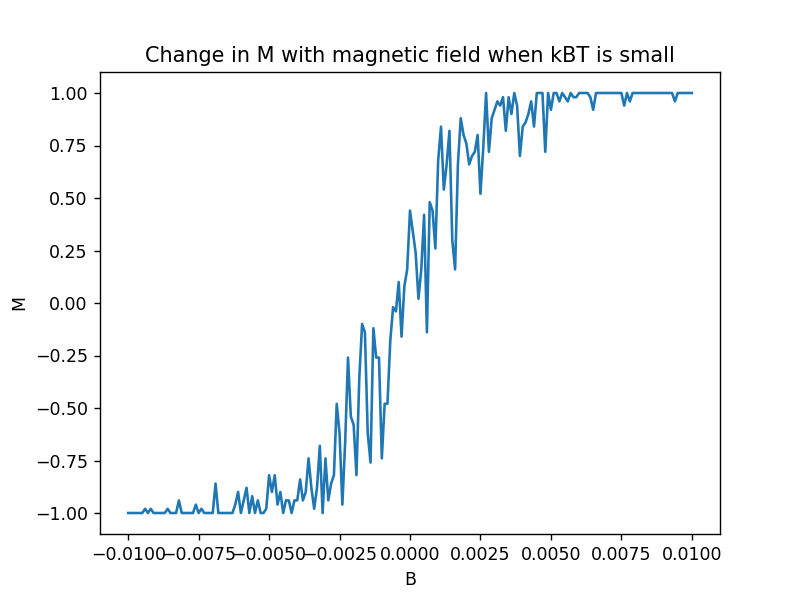

In [81]:
# Step 5: (Continued) 
# Investigate the role of magnetic field on magnetization (When kBT = 0.01)

kBT = 0.01 # When temperature is very low. The exponential term in single_flip() goes to 0. So spontaneous flipping rarely happens.

length = 100 # 100 seems like a reasonably sized chain
time_steps = 100*10 # 1000 time steps for a chain of length of 100 means that on average there will be 10 attempts per chain element. We hope this is a reasonable estimate of the number of time steps needed for the M to reach a constant value.

# For this purpose we will use a magnetic field strength range from -0.01 to +0.01 with a step size of 0.0001
B = range(-100, 101, 1)
B = [ii*(0.0001) for ii in B]


M_list = []

for ii in B:
    m = system_magnetization(kBT, ii, time_steps, length)
    M_list.append(m)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(B, M_list)

ax.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
#ax.set_aspect(aspect = "equal")
plt.show()

# Interpretation:
# M is very sensitive to small changes in B near 0.
# Changing signs of B has a profound effect on M



<IPython.core.display.Javascript object>


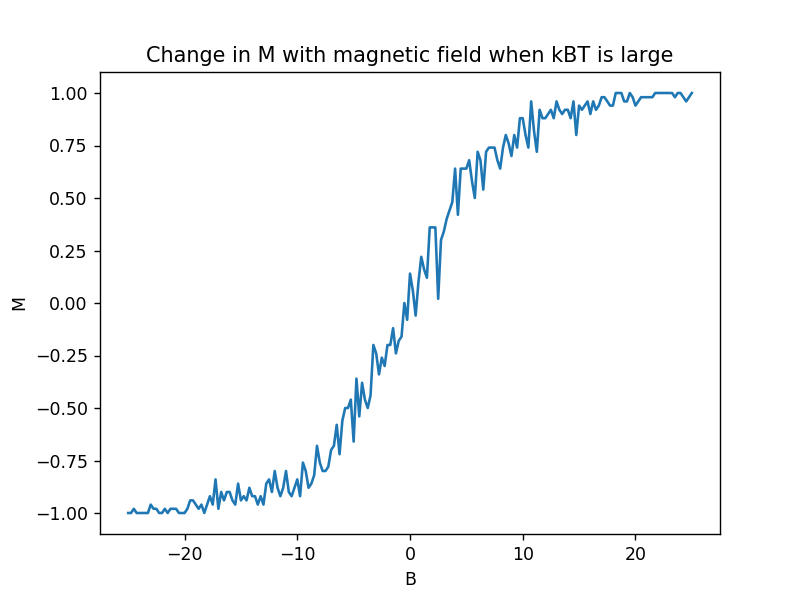

In [82]:
# Step 5: (Continued) 
# Investigate the role of magnetic field on magnetization (When kBT = 10)

kBT = 10 # When temperature is very low. The exponential term in single_flip() goes to 1. So spontaneous flipping happens almost always.

length = 100 # 100 seems like a reasonably sized chain
time_steps = 100*10 # 1000 time steps for a chain of length of 100 means that on average there will be 10 attempts per chain element. We hope this is a reasonable estimate of the number of time steps needed for the M to reach a constant value.

# For this purpose we will use a magnetic field strength range from -25 to +25 with a step size of 0.25
B = range(-100, 101, 1)
B = [ii*(0.25) for ii in B]


M_list = []

for ii in B:
    m = system_magnetization(kBT, ii, time_steps, length)
    M_list.append(m)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(B, M_list)

ax.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is large") 
#ax.set_aspect(aspect = "equal")
plt.show()

# Interpretation:
# M is less sensitive to small changes in B near 0 compared to when kBT = 0.01.
# We observe the same sigmoidal shape of the curve as before but change happens over a much larger interval of B



<IPython.core.display.Javascript object>


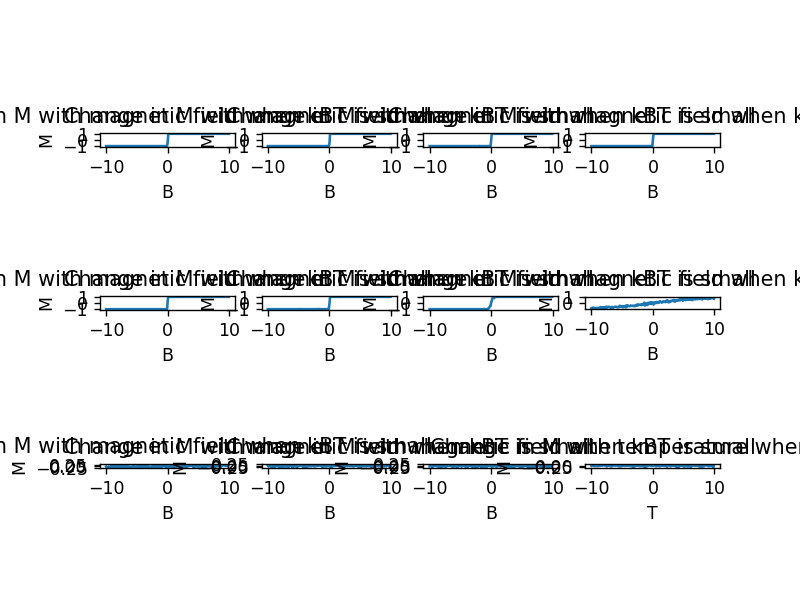

In [78]:
# Obtain plots of  𝑀  vs.  𝐵  for several representative values of  𝑘𝐵𝑇 

length = 100 # 100 seems like a reasonably sized chain
time_steps = 100*10 # 1000 time steps for a chain of length of 100 means that on average there will be 10 attempts per chain element. We hope this is a reasonable estimate of the number of time steps needed for the M to reach a constant value.

kBT = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

# For this purpose we will use a magnetic field strength range from -1000 to 1000 with a step size of 10
B = range(-100, 100, 1)
B = [ii*0.1 for ii in B]

# Create a 3 x 4 figure object
fig = plt.figure()

# Plot 1: kBT=0.000001
ax1 = fig.add_subplot(3,4,1)
M_list = []
for ii in B:
    m = system_magnetization(kBT[0], ii, time_steps, length)
    M_list.append(m)
ax1.plot(B, M_list)
ax1.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax1.set_aspect(aspect = "equal")

# Plot 2: kBT=0.00001
ax2 = fig.add_subplot(3,4,2)
M_list = []
for ii in B:
    m = system_magnetization(kBT[1], ii, time_steps, length)
    M_list.append(m)
ax2.plot(B, M_list)
ax2.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax2.set_aspect(aspect = "equal")


# Plot 3: kBT=0.0001
ax3 = fig.add_subplot(3,4,3)
M_list = []
for ii in B:
    m = system_magnetization(kBT[2], ii, time_steps, length)
    M_list.append(m)
ax3.plot(B, M_list)
ax3.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax3.set_aspect(aspect = "equal")


# Plot 4: kBT=0.001
ax4 = fig.add_subplot(3,4,4)
M_list = []
for ii in B:
    m = system_magnetization(kBT[3], ii, time_steps, length)
    M_list.append(m)
ax4.plot(B, M_list)
ax4.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax4.set_aspect(aspect = "equal")


# Plot 5: kBT=0.01
ax5 = fig.add_subplot(3,4,5)
M_list = []
for ii in B:
    m = system_magnetization(kBT[4], ii, time_steps, length)
    M_list.append(m)
ax5.plot(B, M_list)
ax5.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax5.set_aspect(aspect = "equal")


# Plot 6: kBT=0.1
ax6 = fig.add_subplot(3,4,6)
M_list = []
for ii in B:
    m = system_magnetization(kBT[5], ii, time_steps, length)
    M_list.append(m)
ax6.plot(B, M_list)
ax6.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax6.set_aspect(aspect = "equal")


# Plot 7: kBT=1
ax7 = fig.add_subplot(3,4,7)
M_list = []
for ii in B:
    m = system_magnetization(kBT[6], ii, time_steps, length)
    M_list.append(m)
ax7.plot(B, M_list)
ax7.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax7.set_aspect(aspect = "equal")


# Plot 8: kBT=10
ax8 = fig.add_subplot(3,4,8)
M_list = []
for ii in B:
    m = system_magnetization(kBT[7], ii, time_steps, length)
    M_list.append(m)
ax8.plot(B, M_list)
ax8.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax8.set_aspect(aspect = "equal")


# Plot 9: kBT=100
ax9 = fig.add_subplot(3,4,9)
M_list = []
for ii in B:
    m = system_magnetization(kBT[8], ii, time_steps, length)
    M_list.append(m)
ax9.plot(B, M_list)
ax9.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax9.set_aspect(aspect = "equal")


# Plot 10: kBT=1000
ax10 = fig.add_subplot(3,4,10)
M_list = []
for ii in B:
    m = system_magnetization(kBT[9], ii, time_steps, length)
    M_list.append(m)
ax10.plot(B, M_list)
ax10.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax10.set_aspect(aspect = "equal")


# Plot 11: kBT=10000
ax11 = fig.add_subplot(3,4,11)
M_list = []
for ii in B:
    m = system_magnetization(kBT[10], ii, time_steps, length)
    M_list.append(m)
ax11.plot(B, M_list)
ax11.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax11.set_aspect(aspect = "equal")


# Plot 12: kBT=100000
ax12 = fig.add_subplot(3,4,12)
M_list = []
for ii in B:
    m = system_magnetization(kBT[11], ii, time_steps, length)
    M_list.append(m)
ax12.plot(B, M_list)
ax12.set(xlabel = "B"
      , ylabel = "M"
      , title = "Change in M with magnetic field when kBT is small") 
ax12.set_aspect(aspect = "equal")


# Interpretation:

# For very small temperatures, the plot of M vs B is essentially a step function. For very small changes of B around 0, M makes the shift to a predominantly up-spin or down-spin dominated configuration.
# See plots 1 through 7
# The temperature is too low in these plots for the spin to spontaneously flip

# For very large temperatures, the plot of M vs B is essentially stretched along the B axis. 
# See plots 8 through 12
# A stronger magnetic field (much higher absolute B values) is needed to lock the configuration in an up or down dominated state
# Otherwise, the temperature is high enough to spontaneously flip a spin



<IPython.core.display.Javascript object>


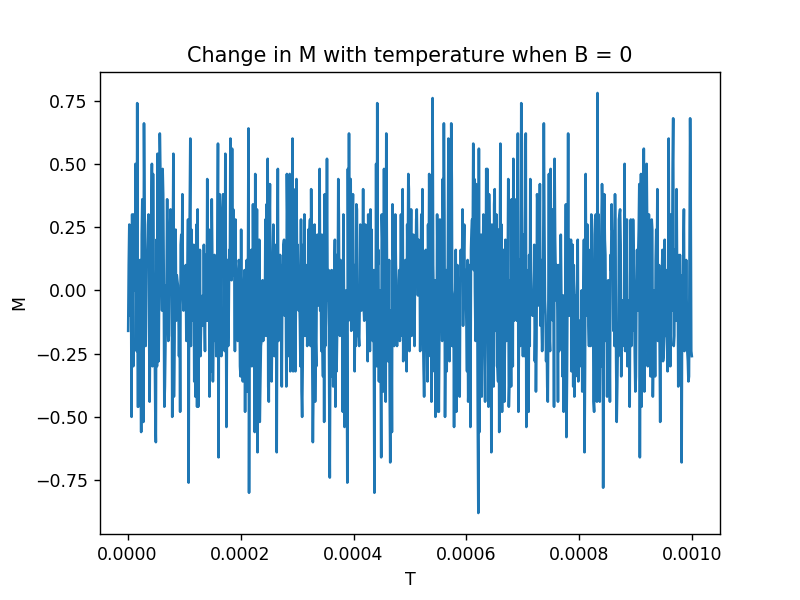

[Text(0, 0.5, 'M'),
 Text(0.5, 0, 'T'),
 Text(0.5, 1.0, 'Change in M with temperature when B = 0')]

In [93]:
# Can you get your system to have a finite  𝑀  at any  𝑇  for  𝐵=0 ?
# For very small values of temperature

B = 0 # Theoretically neither up-spins nor down-spins will be preferred. 
length = 100 # 100 seems like a reasonably sized chain
time_steps = 100*10 # 1000 time steps for a chain of length of 100 means that on average there will be 10 attempts per chain element. We hope this is a reasonable estimate of the number of time steps needed for the M to reach a constant value.


temp_range = range(1, 1000, 1)  

kBT = [(0.000001 * ii) for ii in temp_range] 

M_list = []

for ii in kBT:
    m = system_magnetization(ii, B, time_steps, length)
    M_list.append(m)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(kBT, M_list)

ax.set(xlabel = "T"
      , ylabel = "M"
      , title = "Change in M with temperature when B = 0") 
#ax.set_aspect(aspect = "equal")

# Interpretation:
# For very small values of temperature the magnetization of the system fluctuates 
# M does not have a finite value


<IPython.core.display.Javascript object>


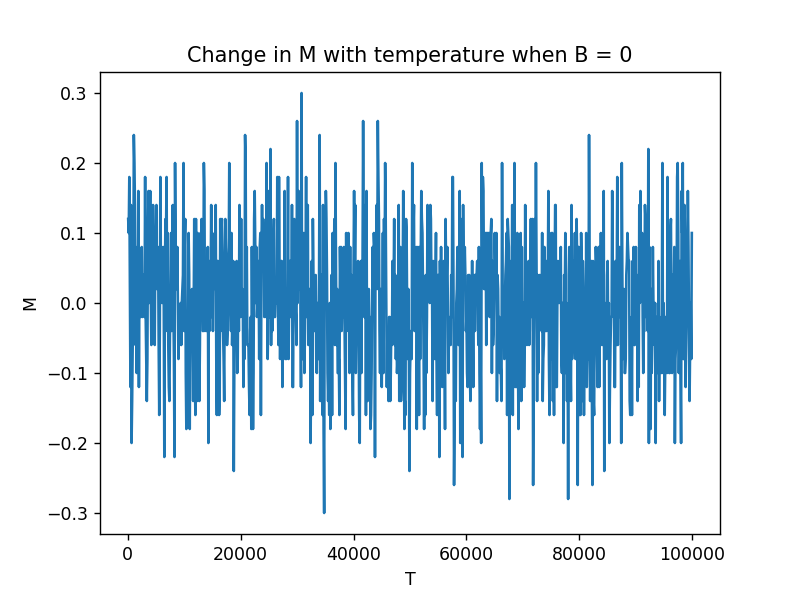

[Text(0, 0.5, 'M'),
 Text(0.5, 0, 'T'),
 Text(0.5, 1.0, 'Change in M with temperature when B = 0')]

In [92]:
# Can you get your system to have a finite  𝑀  at any  𝑇  for  𝐵=0 ?
# For very large values of temperature

B = 0 # Theoretically neither up-spins nor down-spins will be preferred. 
length = 100 # 100 seems like a reasonably sized chain
time_steps = 100*10 # 1000 time steps for a chain of length of 100 means that on average there will be 10 attempts per chain element. We hope this is a reasonable estimate of the number of time steps needed for the M to reach a constant value.


temp_range = range(1, 1000, 1)  

kBT = [(100 * ii) for ii in temp_range] 

M_list = []

for ii in kBT:
    m = system_magnetization(ii, B, time_steps, length)
    M_list.append(m)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(kBT, M_list)

ax.set(xlabel = "T"
      , ylabel = "M"
      , title = "Change in M with temperature when B = 0") 
#ax.set_aspect(aspect = "equal")

# Interpretation:
# Even For very large values of temperature the magnetization of the system fluctuates 
# M does not have a finite value
# But interestingly instead of fluctuating between +1 and -1 it fluctuates within a much narrower range of +0.3 and -0.3

In [95]:
# Show that your results agree with the formula.
# Function to calculate theoretical (analytical) magnetization
def analytical_magnetization(kBT, B):
    numerator = np.sinh(B / kBT)
    denominator = np.sqrt( (np.exp( -4 / (kBT))) + ( np.sinh( B / kBT) )**2 )
    if denominator != 0:
        M = numerator / denominator
    else:
        M = "undefined"
    return M

In [209]:
# Case 1: B>0 and T low
B = 0.1
kBT = 0.01
time_steps = 100*10
length = 100

analytical_value = analytical_magnetization(kBT, B)
#print(analytical_value)

numerical_value = system_magnetization(kBT, B, time_steps, length)
#print(numerical_value)

print("Case 1: The numerical value of our magnetization is %f, while the analytical value is %f" %(numerical_value, analytical_value))

# Case 2: B<0 and T low
B = -0.1
kBT = 0.01
time_steps = 100*10
length = 100

analytical_value = analytical_magnetization(kBT, B)
#print(analytical_value)

numerical_value = system_magnetization(kBT, B, time_steps, length)
#print(numerical_value)

print("Case 2: The numerical value of our magnetization is %f, while the analytical value is %f" %(numerical_value, analytical_value))

# Case 3: B>0 and T high
B = 0.1
kBT = 100
time_steps = 100*10
length = 100

analytical_value = analytical_magnetization(kBT, B)
#print(analytical_value)

numerical_value = system_magnetization(kBT, B, time_steps, length)
#print(numerical_value)

print("Case 3: The numerical value of our magnetization is %f, while the analytical value is %f" %(numerical_value, analytical_value))

# Case 4: B<0 and T high
B = -0.1
kBT = 100
time_steps = 100*10
length = 100

analytical_value = analytical_magnetization(kBT, B)
#print(analytical_value)

numerical_value = system_magnetization(kBT, B, time_steps, length)
#print(numerical_value)

print("Case 4: The numerical value of our magnetization is %f, while the analytical value is %f" %(numerical_value, analytical_value))

# Case 5: B=0 and T comparable (Similar to Delta E)
B = 0
kBT = 2
time_steps = 100*10
length = 100

analytical_value = analytical_magnetization(kBT, B)
#print(analytical_value)

numerical_value = system_magnetization(kBT, B, time_steps, length)
#print(numerical_value)

print("Case 5: The numerical value of our magnetization is %f, while the analytical value is %f" %(numerical_value, analytical_value))

# Case 6: B=0 and T is low
B = 0
kBT = 0.01
time_steps = 100*10
length = 100

analytical_value = analytical_magnetization(kBT, B)
#print(analytical_value)

numerical_value = system_magnetization(kBT, B, time_steps, length)
#print(numerical_value)

print("Case 6: The numerical value of our magnetization is %f, while the analytical value is %f" %(numerical_value, analytical_value))

# Case 7: B=0 and T is high
B = 0
kBT = 100
time_steps = 100*10
length = 100

analytical_value = analytical_magnetization(kBT, B)
#print(analytical_value)

numerical_value = system_magnetization(kBT, B, time_steps, length)
#print(numerical_value)

print("Case 7: The numerical value of our magnetization is %f, while the analytical value is %f" %(numerical_value, analytical_value))

# Interpretation:  
# At higher temperatures, the magnetization value fluctuates for the numerical solution. Look at cases 3 and 4 in compared to cases 1 and 2.
# While, the analytical solution is always exact regardless of temperature.
# When B=0, the numerical solution fluctuates regardless of temperature


Case 1: The numerical value of our magnetization is 1.000000, while the analytical value is 1.000000
Case 2: The numerical value of our magnetization is -1.000000, while the analytical value is -1.000000
Case 3: The numerical value of our magnetization is 0.040000, while the analytical value is 0.001020
Case 4: The numerical value of our magnetization is 0.140000, while the analytical value is -0.001020
Case 5: The numerical value of our magnetization is 0.180000, while the analytical value is 0.000000
Case 6: The numerical value of our magnetization is -0.380000, while the analytical value is 0.000000
Case 7: The numerical value of our magnetization is -0.040000, while the analytical value is 0.000000
